In [1]:
import time
import tensorflow as tf
import numpy as np
from glob import glob
import datetime
import random
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from  tensorflow import keras
from  tensorflow.keras import layers
import base64
import cv2
import os
from tqdm import tqdm
from tensorflow.keras.utils import img_to_array
import re
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD
from keras.optimizers import Adam
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping

### Preprocess dataset

In [2]:
print("[INFO] loading images...")
time1 = time.time()   # to measure time taken
data = []
labels = []

SIZE = 128
SCALE = 255
SEED = 1337

# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images('train')))   # data folder with 3 categorical folders
random.seed(SEED)
random.shuffle(imagePaths)

# loop over the input images
for imagePath in imagePaths:
    # load the image, resize the image to be 128x128 pixels 
    # flatten the 128x128x3=49152 pixel image into a list, and store the image in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (SIZE, SIZE)).flatten()
    data.append(image)
 
    # extract the class label from the image path and update the labels list
    label = imagePath.split(os.path.sep)[1]
    labels.append(label)

# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / SCALE
labels = np.array(labels)

print('Time taken: {:.1f} seconds'.format(time.time() - time1))   # to measure time taken
print("done")

[INFO] loading images...
Time taken: 119.1 seconds
done


In [3]:
# partition the data into 80% training and 20% validation
(trainX, valX, trainY, valY) = train_test_split(data, labels, test_size=0.2, random_state=SEED)

In [4]:
# convert label to binary
lb = preprocessing.LabelBinarizer()
trainY = lb.fit_transform(trainY)
valY = lb.transform(valY)

In [5]:
# check class label: norm - 0 weap - 1
lb.classes_

array(['norm', 'weap'], dtype='<U4')

### Build model

In [6]:
# define the 49152-1024-512-1 architecture using Keras

model = Sequential()   # input layer 49152 as there are 128*128*3=49152 pixels in a flattened input image
model.add(Dense(1024, input_shape=(49152,), activation="relu"))   # first hidden layer has 1024 nodes
model.add(Dense(512, activation="relu"))                         # second hidden layer has 512 nodes
model.add(Dense(1, activation="sigmoid"))            # output layer with number of possible class labels

In [19]:
# initialize our initial learning rate and # of epochs to train for
INIT_LR = 0.0005
EPOCHS = 20
 
print("[INFO] training network...")
opt = Adam(learning_rate=INIT_LR)   # default learning_rate=0.001
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] training network...


In [20]:
# train the neural network on training data set
# batch_size (32) controls the size of each group of data to pass through the network. 
time1 = time.time()   # to measure time taken
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)
H = model.fit(trainX, trainY, validation_data=(valX, valY), epochs=EPOCHS, batch_size=32, callbacks=[es])
print('Time taken: {:.1f} seconds'.format(time.time() - time1))   # to measure time taken

Epoch 1/20
114/114 [==============================] - 2s 15ms/step - loss: 0.3454 - accuracy: 0.8568 - val_loss: 0.4981 - val_accuracy: 0.7812
Epoch 2/20
114/114 [==============================] - 1s 11ms/step - loss: 0.2909 - accuracy: 0.8756 - val_loss: 0.3719 - val_accuracy: 0.8608
Epoch 3/20
114/114 [==============================] - 1s 10ms/step - loss: 0.2205 - accuracy: 0.9101 - val_loss: 0.8861 - val_accuracy: 0.7304
Epoch 4/20
114/114 [==============================] - 1s 11ms/step - loss: 0.2512 - accuracy: 0.8944 - val_loss: 0.3640 - val_accuracy: 0.8674
Epoch 5/20
114/114 [==============================] - 1s 11ms/step - loss: 0.1969 - accuracy: 0.9187 - val_loss: 0.3866 - val_accuracy: 0.8762
Epoch 6/20
114/114 [==============================] - 1s 10ms/step - loss: 0.1836 - accuracy: 0.9245 - val_loss: 0.4125 - val_accuracy: 0.8442
Epoch 7/20
114/114 [==============================] - 1s 10ms/step - loss: 0.1995 - accuracy: 0.9187 - val_loss: 0.3682 - val_accuracy: 0.8641

### Visualization on training accuracy

In [21]:
print("[INFO] evaluating network...")
predictions = model.predict(valX, batch_size=32)
predictions = (predictions>0.5)
print(classification_report(valY, predictions))

[INFO] evaluating network...
29/29 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.88      0.95      0.92       540
           1       0.92      0.82      0.86       365

    accuracy                           0.90       905
   macro avg       0.90      0.88      0.89       905
weighted avg       0.90      0.90      0.89       905



In [22]:
H.history["loss"]

[0.3453872799873352,
 0.29086199402809143,
 0.2204541563987732,
 0.251169890165329,
 0.1968832015991211,
 0.18364693224430084,
 0.19952508807182312,
 0.14872713387012482,
 0.15801936388015747,
 0.21096554398536682,
 0.15870888531208038,
 0.09960479289293289,
 0.13647860288619995,
 0.10332109034061432]

In [23]:
len(H.history["val_loss"])

14

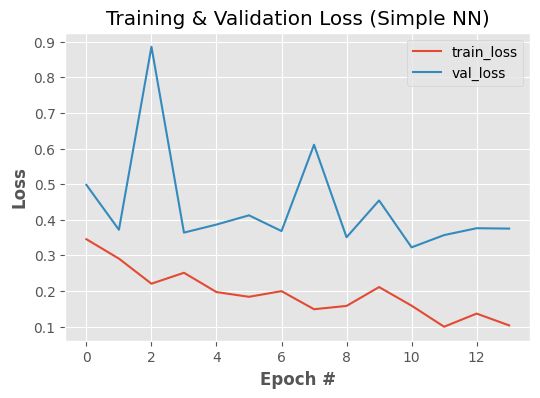

In [24]:
# plot the training and validation loss
N = np.arange(0,  len(H.history["val_loss"]))
plt.style.use("ggplot")
plt.figure(figsize = [6,4])
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training & Validation Loss (Simple NN)")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend()
plt.show()

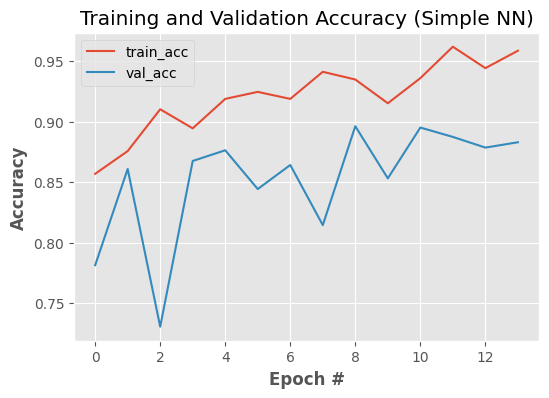

In [26]:
# plot the training and validation accuracy
N = np.arange(0,  len(H.history["val_loss"]))
plt.style.use("ggplot")
plt.figure(figsize = [6,4])
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training and Validation Accuracy (Simple NN)")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend()
plt.show()

### Test Dataset Accuracy

In [28]:
print("[INFO] loading test images...")
time1 = time.time()   # to measure time taken
testX = []
testY = []

SIZE = 128
SCALE = 255
SEED = 1337

# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images('test')))   # data folder with 3 categorical folders
random.seed(SEED)
random.shuffle(imagePaths)

# loop over the input images
for imagePath in imagePaths:
    # load the image, resize the image to be 128x128 pixels 
    # flatten the 128x128x3=49152 pixel image into a list, and store the image in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (SIZE, SIZE)).flatten()
    testX.append(image)
 
    # extract the class label from the image path and update the labels list
    label = imagePath.split(os.path.sep)[1]
    testY.append(label)

# scale the raw pixel intensities to the range [0, 1]
testX = np.array(testX, dtype="float") / SCALE
testY = np.array(testY)

print('Time taken: {:.1f} seconds'.format(time.time() - time1))   # to measure time taken
print("done")

[INFO] loading test images...
Time taken: 58.4 seconds
done


In [29]:
testY = lb.transform(testY)

In [37]:
predictions = model.predict(testX, batch_size=16)
predictions = (predictions>0.5)
print(classification_report(testY, predictions))

128/128 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.65      0.78      0.71      1271
           1       0.46      0.31      0.37       775

    accuracy                           0.60      2046
   macro avg       0.56      0.54      0.54      2046
weighted avg       0.58      0.60      0.58      2046



In [34]:
# double check on accuracy to be the same as above
correct_example = 0
for i in range(len(predictions)):
    if int(predictions[i]) == testY[i]:
        correct_example += 1
print(correct_example / len(predictions))  

0.6021505376344086
